In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
ita = gpd.read_file("italian-maps-shapefiles/italy-with-regions/reg2011_g.shp")
lmb = ita[ita["NOME_REG"]=="LOMBARDIA"]
display(lmb.crs)

lmb.head()

<Projected CRS: EPSG:23032>
Name: ED50 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - between 6°E and 12°E - Denmark - onshore and offshore; France - offshore; Germany offshore; Italy - onshore and offshore; Netherlands offshore; Norway including Svalbard - onshore and offshore.
- bounds: (5.99, 36.53, 12.01, 83.92)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Datum 1950
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

,COD_REG,NOME_REG,SHAPE_Leng,SHAPE_Area,geometry
2,3,LOMBARDIA,1.411265e+06,2.386270e+10,"MULTIPOLYGON (((595736.187 5163715.001, 596126..."


In [3]:
lmb_p = gpd.read_file("italian-maps-shapefiles/regions-with-provinces/lombardia/lombardia.shp")
lmb_p.head()

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,3,13,COMO,260843.128783,1.279089e+09,"MULTIPOLYGON (((521630.187 5120831.002, 521739..."
1,3,12,VARESE,245849.447397,1.199042e+09,"POLYGON ((483154.593 5104805.000, 483341.500 5..."
2,3,15,MILANO,309551.691373,1.575269e+09,"MULTIPOLYGON (((495404.523 5054547.920, 495509..."
3,3,18,PAVIA,450740.523680,2.968156e+09,"MULTIPOLYGON (((488156.944 5026523.092, 488089..."
4,3,16,BERGAMO,311027.307255,2.745545e+09,"POLYGON ((585372.000 5104682.001, 585498.437 5..."


In [4]:
lmb_p["interventi"] = [0,5,14,4,0,0,0,0,0,3,3,2]

In [5]:
# http://www.geoin.it/coordinate_converter/

cities = pd.DataFrame({
    "city": ["Linate","Lecco","Monza", "Caponago","Meda","Voghera","Vigevano","Pavia","Mantova"],
    "lng": [521605.70,530957.66,521406.90,529412.52,511873.08,500945.96,487105.63,512429.03,640811.54],
    "lat": [5033317.56,5078390.58,5048015.72,5046081.67,5056500.90,4982121.14,5018106.44,5003574.12,5001979.03],
})

cities_geo = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lng, cities.lat))
cities_geo['coords'] = cities_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
cities_geo['coords'] = [coords[0] for coords in cities_geo['coords']]
cities_geo = cities_geo.sort_values(by="city")
cities_geo

,city,lng,lat,geometry,coords
3,Caponago,529412.52,5046081.67,POINT (529412.520 5046081.670),"(529412.52, 5046081.67)"
1,Lecco,530957.66,5078390.58,POINT (530957.660 5078390.580),"(530957.66, 5078390.58)"
0,Linate,521605.70,5033317.56,POINT (521605.700 5033317.560),"(521605.7, 5033317.56)"
8,Mantova,640811.54,5001979.03,POINT (640811.540 5001979.030),"(640811.54, 5001979.03)"
4,Meda,511873.08,5056500.90,POINT (511873.080 5056500.900),"(511873.08, 5056500.9)"
2,Monza,521406.90,5048015.72,POINT (521406.900 5048015.720),"(521406.9, 5048015.72)"
7,Pavia,512429.03,5003574.12,POINT (512429.030 5003574.120),"(512429.03, 5003574.12)"
6,Vigevano,487105.63,5018106.44,POINT (487105.630 5018106.440),"(487105.63, 5018106.44)"
5,Voghera,500945.96,4982121.14,POINT (500945.960 4982121.140),"(500945.96, 4982121.14)"


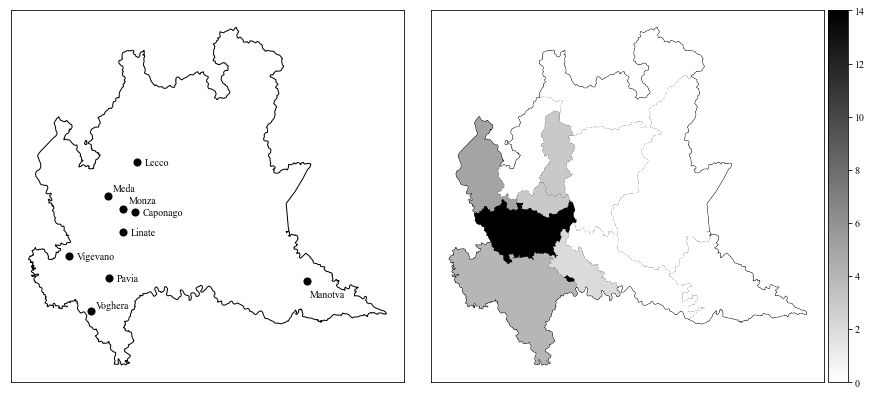

In [6]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

lmb.plot(facecolor="#fff", edgecolor="#000", ax=ax1)


divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cax1.get_xaxis().set_visible(False)
cax1.get_yaxis().set_visible(False)
cax1.spines['right'].set_visible(False)
cax1.spines['left'].set_visible(False)
cax1.spines['top'].set_visible(False)
cax1.spines['bottom'].set_visible(False)


lmb_p.plot(facecolor="#fff", edgecolor="#000", ax=ax2)
lmb_p.plot(column='interventi', cmap='gray_r', ax=ax2)

cities_geo.plot(marker="o", markersize=50, color="#000", ax=ax1)

caponago = cities_geo[cities_geo["city"] == "Caponago"]
lecco = cities_geo[cities_geo["city"] == "Lecco"]
linate = cities_geo[cities_geo["city"] == "Linate"]
meda = cities_geo[cities_geo["city"] == "Meda"]
mantova = cities_geo[cities_geo["city"] == "Mantova"]
monza = cities_geo[cities_geo["city"] == "Monza"]
pavia = cities_geo[cities_geo["city"] == "Pavia"]
vigevano = cities_geo[cities_geo["city"] == "Vigevano"]
voghera = cities_geo[cities_geo["city"] == "Voghera"]


for city, x, y in [
    ("Caponago", caponago.coords.to_list()[0][0]+5000, caponago.coords.to_list()[0][1]-2000),
    ("Lecco", lecco.coords.to_list()[0][0]+5000, lecco.coords.to_list()[0][1]-2000),
    ("Linate", linate.coords.to_list()[0][0]+5000, linate.coords.to_list()[0][1]-2000),
    ("Meda", meda.coords.to_list()[0][0]+3000, meda.coords.to_list()[0][1]+3000),
    ("Manotva", mantova.coords.to_list()[0][0]+1500, mantova.coords.to_list()[0][1]-11000),
    ("Monza", monza.coords.to_list()[0][0]+4000, monza.coords.to_list()[0][1]+3800),
    ("Pavia", pavia.coords.to_list()[0][0]+5000, pavia.coords.to_list()[0][1]-2000),
    ("Vigevano", vigevano.coords.to_list()[0][0]+5000, vigevano.coords.to_list()[0][1]-2000),
    ("Voghera", voghera.coords.to_list()[0][0]+3000, voghera.coords.to_list()[0][1]+2000)
]:
    ax1.annotate(city, (x,y))

norm = colors.Normalize(vmin=lmb_p.interventi.min(), vmax=lmb_p.interventi.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='gray_r')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(cbar, cax=cax2)

for ax in (ax1,ax2):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

fig.subplots_adjust(wspace=0.01)

plt.savefig("geografia interventi.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()
